In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image

from sklearn.model_selection import train_test_split

import os
import json
from collections import Counter
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image

os.chdir('C:\\Users\\nikhi\\Documents\\Projects\\pokemon_classifier_using_vision_transformer')
from configs import path_config, data_config, train_config

from src.visualization import visualize_batch
from src.models import ViT
from src.data import get_dataloader, get_dataset

%reload_ext autoreload
%autoreload 2

**Dataset from Kaggle**

Download link: [Pokemon Images, First Generation(17000 files)](https://www.kaggle.com/datasets/mikoajkolman/pokemon-images-first-generation17000-files)

**Command**

```
kaggle datasets download -d mikoajkolman/pokemon-images-first-generation17000-files
```

### Inspecting files

In [35]:
"""
    Inspecting file types present in the dataset
"""
extensions = defaultdict(lambda:0)
for root, dirs, files in tqdm(os.walk(path_config.dataset_path)):
    for f in files:
        ext = os.path.splitext(f)[-1]
        extensions[ext] += 1
        
extensions

0it [00:00, ?it/s]

defaultdict(<function __main__.<lambda>()>,
            {'.png': 5637,
             '.gif': 776,
             '.jpg': 10765,
             '.jpeg': 63,
             '.PNG': 9,
             '.JPG': 8,
             '.bmp': 3})

In [34]:
"""
    Removing incompatible files
"""
for root, dirs, files in tqdm(os.walk(path_config.dataset_path)):
    for f in files:
        ext = os.path.splitext(f)[-1]
        if ext in ('.ini', '.svg'):
            f_path = os.path.join(root, f)
            os.remove(f_path)
            print("Removing file\n", f_path)

0it [00:00, ?it/s]

Removing file
 c:\Users\nikhi\Documents\Projects\pokemon_classifier_using_vision_transformer\data\raw\pokemon-images-first-generation17000-files\pokemon\Abra\desktop.ini
Removing file
 c:\Users\nikhi\Documents\Projects\pokemon_classifier_using_vision_transformer\data\raw\pokemon-images-first-generation17000-files\pokemon\Tentacruel\d6fb0a3046364ea2b49525c6f6b966e5.svg


In [39]:
"""
    Number of examples per class
"""
class_dirs = os.listdir(path_config.dataset_path)

class_dist = {class_dir: len(os.listdir(os.path.join(path_config.dataset_path, class_dir))) 
                for class_dir in class_dirs}
class_dist

{'Abra': 62,
 'Aerodactyl': 91,
 'Alakazam': 90,
 'Arbok': 137,
 'Arcanine': 85,
 'Articuno': 94,
 'Beedrill': 90,
 'Bellsprout': 145,
 'Blastoise': 146,
 'Bulbasaur': 149,
 'Butterfree': 126,
 'Caterpie': 145,
 'Chansey': 116,
 'Charizard': 105,
 'Charmander': 132,
 'Charmeleon': 147,
 'Clefable': 109,
 'Clefairy': 109,
 'Cloyster': 96,
 'Cubone': 122,
 'Dewgong': 115,
 'Diglett': 90,
 'Ditto': 81,
 'Dodrio': 92,
 'Doduo': 92,
 'Dragonair': 127,
 'Dragonite': 150,
 'Dratini': 121,
 'Drowzee': 111,
 'Dugtrio': 121,
 'Eevee': 147,
 'Ekans': 123,
 'Electabuzz': 126,
 'Electrode': 62,
 'Exeggcute': 126,
 'Exeggutor': 173,
 'Farfetchd': 133,
 'Fearow': 146,
 'Flareon': 169,
 'Gastly': 160,
 'Gengar': 151,
 'Geodude': 95,
 'Gloom': 75,
 'Golbat': 142,
 'Goldeen': 120,
 'Golduck': 160,
 'Graveler': 84,
 'Grimer': 81,
 'Growlithe': 122,
 'Gyarados': 155,
 'Haunter': 118,
 'Hitmonchan': 114,
 'Hitmonlee': 105,
 'Horsea': 132,
 'Hypno': 73,
 'Ivysaur': 154,
 'Jigglypuff': 196,
 'Jolteon': 128,


### Finding the Mean and Standard Deviation of Image Channels

In [36]:
transforms = v2.Compose([
    v2.PILToTensor(),
    v2.Resize((224,224)),
    v2.ToDtype(torch.float32, scale=True),
])
dataset = ImageFolder(root=path_config.dataset_path, transform=transforms)
dataloader = DataLoader(dataset, batch_size=8)

In [38]:
mean = 0
std = 0
n_images = 0

for batch in tqdm(dataloader):
    images, _ = batch
    images = images.view(images.size(0), images.size(1), -1) # [B, C, W*H]
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    n_images += images.size(0)

mean /= n_images
std /= n_images

print(mean)
print(std)

  0%|          | 0/2061 [00:00<?, ?it/s]

c:\Users\nikhi\AppData\Local\pypoetry\Cache\virtualenvs\pokemon-classifier-using-vision-transforme-Mz_9FrSk-py3.11\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


tensor([0.5972, 0.5810, 0.5484])
tensor([0.2495, 0.2412, 0.2481])


### Testing Dataloaders

In [8]:
try:
    train_config = train_config.experiments.dryrun
except:
    print("Already set")

Already set


In [9]:
trainset, valset = get_dataset(train=True, train_config=train_config)
trainloader = get_dataloader(trainset, train_config, True)
valloader = get_dataloader(valset, train_config, True)

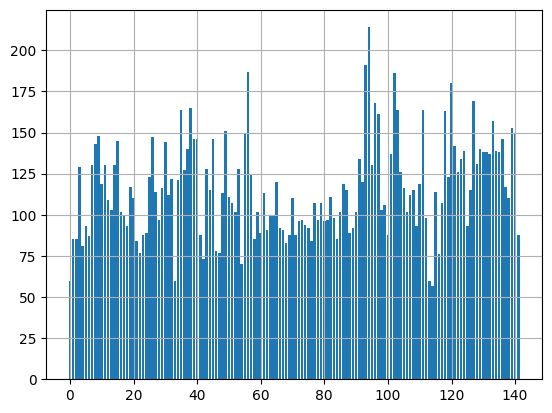

In [5]:
class_dist = Counter(trainset.dataset.targets)
x = np.arange(max(trainset.dataset.targets)+1)
y = [class_dist[c] for c in x]
plt.bar(x, y)
plt.grid()
plt.show()

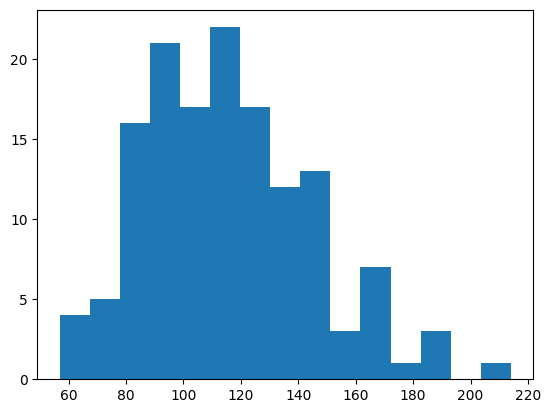

In [6]:
plt.hist(y, bins = 15)
plt.show()

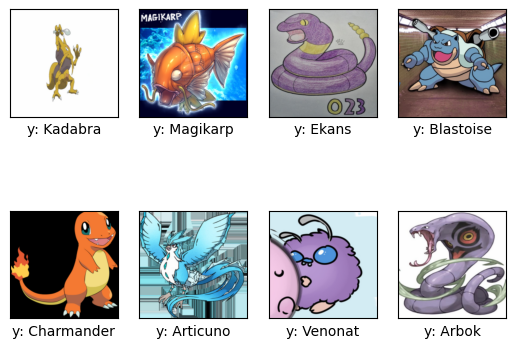

In [10]:
images, labels = next(iter(trainloader))
visualize_batch(images, labels)

### Testing model code

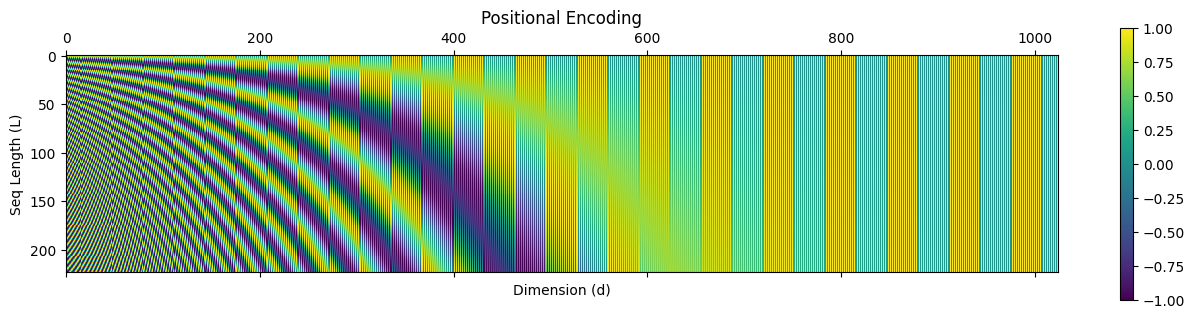

In [11]:
def get_pos_enc(seq_len, d, n=10000):
    """
        seq_len: Length of Sequence (L)
        d: Dimensionality of each Sequence
        n: Scalar
    """
    pe = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in range(d//2):
            denominator = n**(2*i/d)
            pe[k, 2*i] = np.sin(k/denominator)
            pe[k, 2*i+1] = np.cos(k/denominator)
    return torch.Tensor(pe)

cax = plt.matshow(get_pos_enc(14*16, 1024))
plt.gcf().colorbar(cax)
plt.title("Positional Encoding")
plt.xlabel("Dimension (d)")
plt.ylabel("Seq Length (L)")
plt.show()

In [12]:
vit = ViT(data_config, train_config)
print(vit)
print("Output shape:",vit(images).shape)


total_params = sum(param.numel() for param in vit.parameters())
print(f"Total Parameters: {total_params*1e-6:.2f} M")

ViT(
  (embedding): InputEmbeddings(
    (linear_projection): Linear(in_features=768, out_features=512, bias=True)
  )
  (encoders): Sequential(
    (0): Encoder(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attention_block): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
      )
      (mlp_block): Sequential(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0, inplace=False)
        (3): Linear(in_features=2048, out_features=512, bias=True)
        (4): Dropout(p=0, inplace=False)
      )
    )
  )
  (mlp_head): Sequential(
    (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=142, bias=True)
  )
)
Output shape: torch.Size([8, 142])
Total Parameters: 3.89 M
